In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report, make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

In [3]:
working_with_dummies = True
use_StratifiedKFold = True

In [4]:
trn_dataset_with_preprocessing_path = r'../utilfiles/trn_dataset_with_preprocessing.csv'
val_dataset_with_preprocessing_path = r'../utilfiles/val_dataset_with_preprocessing.csv'

trn_dataset_with_dummies_path = r'../utilfiles/train_test_val_files/train_set_with_dummies.csv'
val_dataset_with_dummies_path = r'../utilfiles/train_test_val_files/val_set_with_dummies.csv'

if(working_with_dummies):
    trn_file_path = trn_dataset_with_dummies_path
    val_file_path = val_dataset_with_dummies_path
else:
    trn_file_path = trn_dataset_with_preprocessing_path
    val_file_path = val_dataset_with_preprocessing_path   

In [5]:
full_train_df = pd.read_csv(trn_file_path)
full_val_df = pd.read_csv(val_file_path)

In [6]:
reduced_train_df = full_train_df.sample(frac=0.3, random_state=45)
reduced_val_df = full_val_df.sample(frac=0.3, random_state=42)

In [7]:
X_train = reduced_train_df.drop(columns=['eid', 'target'])
y_train = reduced_train_df['target']

In [8]:
X_validation = reduced_val_df.drop(columns=['eid', 'target'])
y_validation = reduced_val_df['target']

In [9]:
model = xgb.XGBClassifier(objective='binary:logistic', 
                          eval_metric='auc', 
                          scale_pos_weight=(len(y_train)-sum(y_train)) / sum(y_train))

In [10]:
# Set up parameters for XGBoost
params_dist = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth' : np.arange(3, 15, 2),
    'eta' : [0.01, 0.001, 0.1, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'gamma' : [0, 0.1, 0.2, 0.3],
    'min_child_weight' : np.arange(1, 10, 2),
    'reg_alpha' : [0, 0.1, 0.5, 1],
    'reg_lambda' : [0, 0.1, 0.5, 1]
}

In [11]:
scorer = make_scorer(f1_score, pos_label=1)

In [14]:
if use_StratifiedKFold:
    kfold = StratifiedKFold(n_splits=5,
                            shuffle=True,
                            random_state=42
                            )
else:
    kfold = KFold(n_splits=5,
                  shuffle=True,
                  random_state=42
                  )

In [15]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params_dist,
    n_iter=50,
    scoring=scorer,
    cv=kfold,
    verbose=3,
    random_state=42
)  

In [16]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END colsample_bytree=0.6, eta=0.001, gamma=0.1, max_depth=9, min_child_weight=9, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=0.9;, score=0.100 total time= 1.8min
[CV 2/5] END colsample_bytree=0.6, eta=0.001, gamma=0.1, max_depth=9, min_child_weight=9, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=0.9;, score=0.117 total time= 1.9min
[CV 3/5] END colsample_bytree=0.6, eta=0.001, gamma=0.1, max_depth=9, min_child_weight=9, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=0.9;, score=0.112 total time= 1.7min
[CV 4/5] END colsample_bytree=0.6, eta=0.001, gamma=0.1, max_depth=9, min_child_weight=9, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=0.9;, score=0.111 total time= 2.3min
[CV 5/5] END colsample_bytree=0.6, eta=0.001, gamma=0.1, max_depth=9, min_child_weight=9, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=0.9;, score=0.110 total time= 1.1min
[CV 1/5] END colsa

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importa...
                                        'eta': [0.01, 0.001, 0.1, 0.3],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'max_depth': array([ 3,  5,  7,  9, 11, 13]),
                                        'min_child_weight': array([1, 3, 5, 7, 9]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
                   verbose=3)

In [20]:
best_xgb_model = random_search.best_estimator_
best_params = random_search.best_params_

print(f'best estimator: {best_xgb_model},\n\n best params: {best_params}')

best estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric='auc',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...),

 best params: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 9, 'gamma': 0.3, 'eta': 0.01, 'colsample_bytree': 0.9}


In [21]:
y_pred_proba = best_xgb_model.predict_proba(X_train)[:,0]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

youdens_j = tpr -fpr
optimal_idx = np.argmax(youdens_j)
optimal_threshold = thresholds[optimal_idx]

Validation


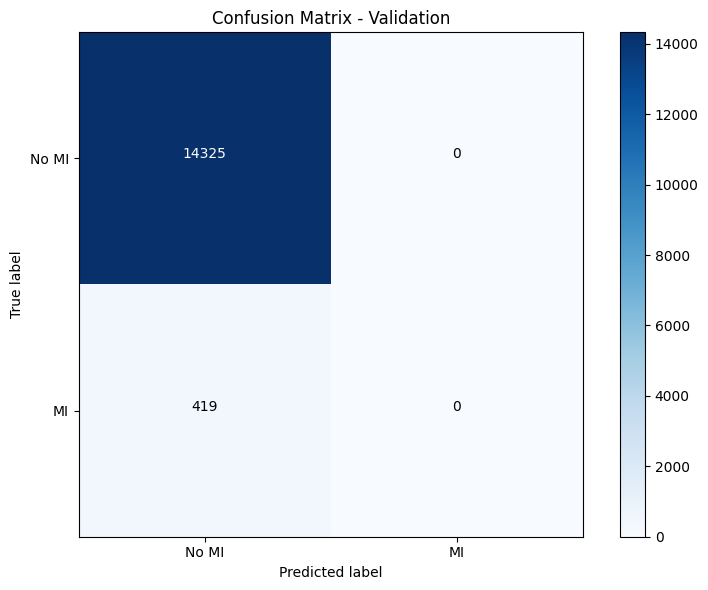

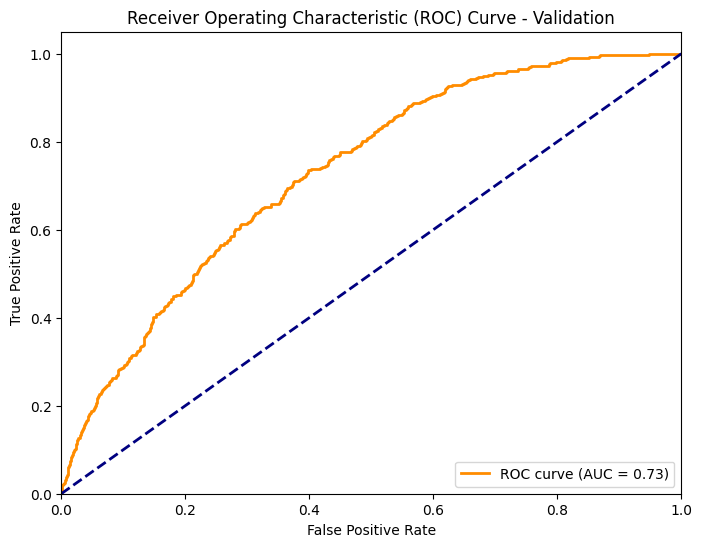

/home/omerkr@mta.ac.il/bioEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/omerkr@mta.ac.il/bioEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/omerkr@mta.ac.il/bioEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     14325
           1       0.00      0.00      0.00       419

    accuracy                           0.97     14744
   macro avg       0.49      0.50      0.49     14744
weighted avg       0.94      0.97      0.96     14744

[[14325     0]
 [  419     0]]
Train


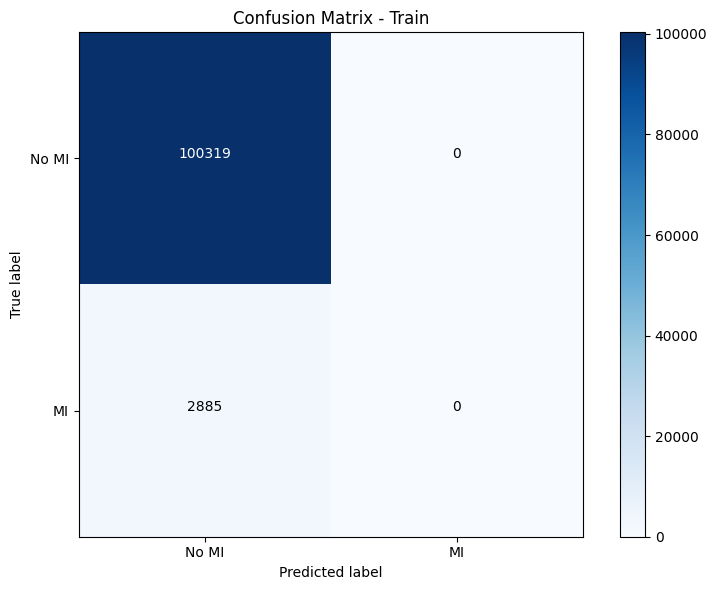

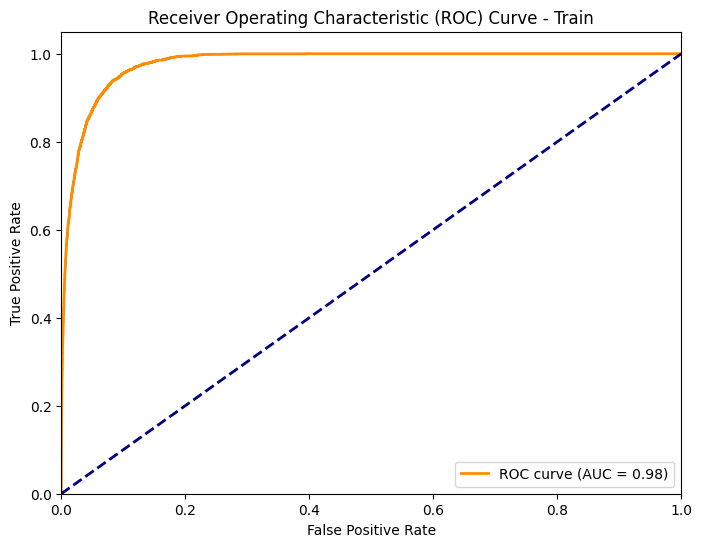

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    100319
           1       0.00      0.00      0.00      2885

    accuracy                           0.97    103204
   macro avg       0.49      0.50      0.49    103204
weighted avg       0.94      0.97      0.96    103204

[[100319      0]
 [  2885      0]]


/home/omerkr@mta.ac.il/bioEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/omerkr@mta.ac.il/bioEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/omerkr@mta.ac.il/bioEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [22]:
threshold = optimal_threshold

# Evaluate the model validation
print(f"Validation")
# Make predictions
y_pred_proba = best_xgb_model.predict_proba(X_validation)[:,1]
y_pred = np.where(y_pred_proba < threshold, 0, 1)

# Confusion Matrix
cm = confusion_matrix(y_validation, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No MI', 'MI'])
plt.yticks(tick_marks, ['No MI', 'MI'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation')
plt.legend(loc="lower right")
plt.show()

print(classification_report(y_true=y_validation,y_pred=y_pred))
print(cm)

# Evaluate the model train
print(f"Train")
# Make predictions
y_pred_proba = best_xgb_model.predict_proba(X_train)[:,1]
y_pred = np.where(y_pred_proba < threshold, 0, 1)

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Train')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No MI', 'MI'])
plt.yticks(tick_marks, ['No MI', 'MI'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Train')
plt.legend(loc="lower right")
plt.show()

print(classification_report(y_true=y_train,y_pred=y_pred))
print(cm)